
# NLP (Natural Language Processing) Spam Filter with Python NLTK




The dataset we are using contains a collection of more than 5 thousand SMS phone messages downloaded from [UCI datasets](https://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection)! which we will be using throughout this project to classify the messages whether it is spam or ham based on its message content using python's NLTK library.

In [17]:
import numpy as np
import pandas as pd
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import  TfidfTransformer
from sklearn.pipeline import Pipeline
from nltk.corpus import stopwords
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix,classification_report
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [18]:
nltk.download_shell()

NLTK Downloader
---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------
Downloader> d

Download which package (l=list; x=cancel)?
  Identifier> stopwords


        C:\Users\munikrishnan\AppData\Roaming\nltk_data...
      Unzipping corpora\stopwords.zip.



---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------
Downloader> q


<div class="alert alert-block alert-info">
<b><font size="4">Exploring the Dataset</font></b>
</div>



In [2]:
messages = pd.read_csv('Downloads/SMSSpamCollection', sep='\t',names=["label", "message"])
messages.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [8]:
messages.describe()

,label,message
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


Let's use **groupby** to use describe by label, this way we can begin to think about the features that separate ham and spam!

In [9]:
messages.groupby('label').describe()

message
label                                                          
ham   count                                                4825
      unique                                               4516
      top                                Sorry, I'll call later
      freq                                                   30
spam  count                                                 747
      unique                                                653
      top     Please call our customer service representativ...
      freq                                                    4

As we continue our analysis we want to start thinking about the features we are going to be using. This goes along with the general idea of [feature engineering](https://en.wikipedia.org/wiki/Feature_engineering). The better your domain knowledge on the data, the better your ability to engineer more features from it. Feature engineering is a very large part of spam detection in general.

Let's make a new column to detect how long the text messages are:

In [3]:
messages['length'] = messages['message'].apply(len)
messages.head()

,label,message,length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


In [58]:
messages['label'].value_counts()

ham     4825
spam     747
Name: label, dtype: int64

<div class="alert alert-block alert-info">
<b><font size="4">Exploratory Data Analysis</font></b>
</div>


Let's visualize this data to get some insights

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

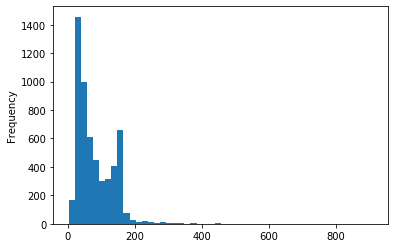

In [5]:
messages['length'].plot(bins=50, kind='hist') 

In [6]:
messages.length.describe()

count    5572.000000
mean       80.489950
std        59.942907
min         2.000000
25%        36.000000
50%        62.000000
75%       122.000000
max       910.000000
Name: length, dtype: float64

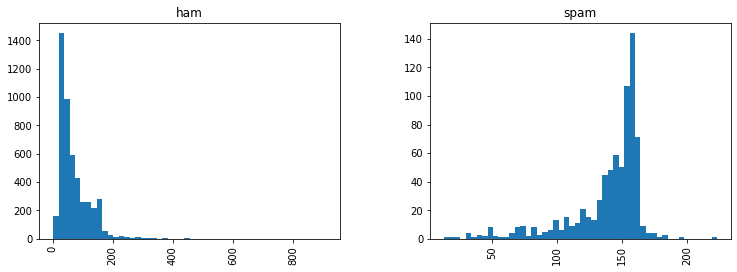

In [8]:
messages.hist(column='length', by='label', bins=50,figsize=(12,4));

We can see that spam messages tend to have more characters. 

<div class="alert alert-block alert-info">
<b><font size="4"> Text Pre-processing: Bag Of Words</font></b>
</div>



Our main issue with our data is that it is all in text format (strings). The classification algorithms that we've learned about so far will need some sort of numerical feature vector in order to perform the classification task. There are actually many methods to convert a corpus to a vector format. The simplest is the the [bag-of-words](http://en.wikipedia.org/wiki/Bag-of-words_model) approach (pythons builtin function ``CountVectorizer``,``TfidfTransformer``), where each unique word in a text will be represented by one/a vector of number.

In this approach we'll convert the raw messages (sequence of characters) into vectors (sequences of numbers) in TWO steps:

1. CountVectorizer

        Assign a fixed integer id to each word occurring in any document of the training set (for instance by building a dictionary from words to integer indices).

        For each document #i, count the number of occurrences of each word w and store it in X[i, j] as the value of feature #j where j is the index of word w in the dictionary.

        The bags of words representation implies that n_features is the number of distinct words in the corpus: this number is typically larger than 100,000.


2. TfidfTransformer

        Occurrence count is a good start but there is an issue: longer documents will have higher average count values than shorter documents, even though they might talk about the same topics.

        To avoid these potential discrepancies it suffices to divide the number of occurrences of each word in a document by the total number of words in the document: these new features are called tf for Term Frequencies.

        Another refinement on top of tf is to downscale weights for words that occur in many documents in the corpus and are therefore less informative than those that occur only in a smaller portion of the corpus.

        This downscaling is called tf–idf for “Term Frequency times Inverse Document Frequency”.

        Both tf and tf–idf can be computed as follows using TfidfTransformer:

BUT FIRST, INORDER TI UNDERSTAND THE CountVectorizer WE WILL WRITE OUR OWN FUNCTION

 let's write a function (``Tokenization``) that will split a message into its individual words and return a list. We'll also remove very common
          words, ('the', 'a', etc..) also known as ``Stopwords``. To do this we will take advantage of the NLTK library. It's pretty much the standard library in Python for processing text and has a lot of useful features. We'll only use some of the basic ones here.

Let's create a function that will process the string in the message column, then we can just use **apply()** in pandas do process all the text in the DataFrame.

First removing punctuation. We can just take advantage of Python's built-in **string** library to get a quick list of all the possible punctuation:

In [9]:
import string

mess = 'Sample message! Notice: it has punctuation.'

# Check characters to see if they are in punctuation
nopunc = [char for char in mess if char not in string.punctuation]

# Join the characters again to form the string.
nopunc = ''.join(nopunc)

Now let's see how to remove stopwords. We can impot a list of english stopwords from NLTK 

In [19]:
from nltk.corpus import stopwords
stopwords.words('english')[0:10] # Show some stop words

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

In [20]:
nopunc.split()

['Sample', 'message', 'Notice', 'it', 'has', 'punctuation']

In [21]:
# Now just remove any stopwords
clean_mess = [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]

In [22]:
clean_mess

['Sample', 'message', 'Notice', 'punctuation']

Now let's put both of these together in a function to apply it to our DataFrame later on:

In [23]:
def text_process(messages):
    """
    Takes in a string of text, then performs the following:
    1. Remove all punctuations from the text
    2. Remove all stopwords from the text
    3. Returns a list of the cleaned text
    """
    # Check characters to see if they are in punctuation
    nopunc = [char for char in messages if char not in string.punctuation]

    # Join the characters again to form the string.
    nopunc = ''.join(nopunc)
    
    # Now just remove any stopwords
    return [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]

In [25]:
messages.head()

,label,message,length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


Now let's "tokenize" these messages. Tokenization is just the term used to describe the process of converting the normal text strings in to a list of tokens (words that we actually want).

Let's see an example output on on column:

**Note:**
We may get some warnings or errors for symbols we didn't account for or that weren't in Unicode (like a British pound symbol)

In [24]:
# Check to make sure its working
messages['message'].head(5).apply(text_process)

0    [Go, jurong, point, crazy, Available, bugis, n...
1                       [Ok, lar, Joking, wif, u, oni]
2    [Free, entry, 2, wkly, comp, win, FA, Cup, fin...
3        [U, dun, say, early, hor, U, c, already, say]
4    [Nah, dont, think, goes, usf, lives, around, t...
Name: message, dtype: object

In [25]:
# Show original dataframe
messages.head()

,label,message,length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


<div class="alert alert-block alert-danger"><b><font size="4"> Continuing Normalization</font></b>



There are a lot of ways to continue normalizing this text. Such as [Stemming](https://en.wikipedia.org/wiki/Stemming) or distinguishing by [part of speech](http://www.nltk.org/book/ch05.html).

NLTK has lots of built-in tools and great documentation on a lot of these methods. Sometimes they don't work well for text-messages due to the way a lot of people tend to use abbreviations or shorthand, For example:
    
    'Nah dawg, IDK! Wut time u headin to da club?'
    
versus

    'No dog, I don't know! What time are you heading to the club?'
    
Some text normalization methods will have trouble with this type of shorthand and so I'll leave you to explore those more advanced methods through the [NLTK book online](http://www.nltk.org/book/).

For now we will just focus on using what we have to convert our list of words to an actual vector that SciKit-Learn can use.
</div>

## Vectorization (CountVectorizer)

Currently, we have the messages as lists of tokens (also known as [lemmas](http://nlp.stanford.edu/IR-book/html/htmledition/stemming-and-lemmatization-1.html)) and now we need to convert each of those messages into a vector the SciKit Learn's algorithm models can work with.

The same Text preprocessing, Tokenizing and filtering of Stopwords or which we wrote a function named ``text_process`` are all included in ``CountVectorizer`` function, along with the count matrix for all the words for the given data which builds a dictionary of features and transforms documents to feature vectors:

After the ``CountVectorizer`` operation We'll do Normalization using the ``TfidfTransformer``


.




**<u>Let's begin the first step  ``CountVectorizer``:</u>**

Each vector will have as many dimensions as there are unique words in the SMS corpus.  We will first use SciKit Learn's **CountVectorizer**. This model will convert a collection of text documents to a matrix of token counts.

We can imagine this as a 2-Dimensional matrix. Where the 1-dimension is the entire vocabulary (1 row per word) and the other dimension are the actual documents, in this case a column per text message. 

For example:

<table border = “1“>
<tr>
<th></th> <th>Message 1</th> <th>Message 2</th> <th>...</th> <th>Message N</th> 
</tr>
<tr>
<td><b>Word 1 Count</b></td><td>0</td><td>1</td><td>...</td><td>0</td>
</tr>
<tr>
<td><b>Word 2 Count</b></td><td>0</td><td>0</td><td>...</td><td>0</td>
</tr>
<tr>
<td><b>...</b></td> <td>1</td><td>2</td><td>...</td><td>0</td>
</tr>
<tr>
<td><b>Word N Count</b></td> <td>0</td><td>1</td><td>...</td><td>1</td>
</tr>
</table>


Since there are so many messages, we can expect a lot of zero counts for the presence of that word in that document. Because of this, SciKit Learn will output a [Sparse Matrix](https://en.wikipedia.org/wiki/Sparse_matrix).

In [27]:
from sklearn.feature_extraction.text import CountVectorizer
#similar to the function which we wrote earlier, bu we have a inbuilt function CountVectorizer which 

There are a lot of arguments and parameters that can be passed to the CountVectorizer. In this case we will just specify the **analyzer** to be our own previously defined function:

In [35]:
# Might take awhile...
bow_transformer = CountVectorizer(analyzer=text_process).fit(messages['message'])#we use only fit not fit_transform
#the fit method only calculates the measures but will not apply the transformation of word to vectorization
#but the fit_transform method will calculate the measures and apply the transformation as well

# Print total number of vocab words
print(len(bow_transformer.vocabulary_) , 'Unique words are present in the entire text dataset')

11425 Unique words are present in the entire text dataset


Let's take one text message and get its bag-of-words counts as a vector, putting to use our new `bow_transformer`:

In [37]:
message4 = messages['message'][3]
print(message4)

U dun say so early hor... U c already then say...


Now let's see its vector representation:

In [38]:
bow4 = bow_transformer.transform([message4])
print(bow4)
print(bow4.shape)

  (0, 4068)	2
  (0, 4629)	1
  (0, 5261)	1
  (0, 6204)	1
  (0, 6222)	1
  (0, 7186)	1
  (0, 9554)	2
(1, 11425)


This means that there are seven unique words in message number 4 (after removing common stop words). Two of them appear twice, the rest only once. Let's go ahead and check and confirm which ones appear twice:

In [39]:
print(bow_transformer.get_feature_names()[4068])
print(bow_transformer.get_feature_names()[9554])

U
say


Now we can use **.transform** on our Bag-of-Words (bow) transformed object and transform the entire DataFrame of messages. Let's go ahead and check out how the bag-of-words counts for the entire SMS corpus is a large, sparse matrix:

In [40]:
messages_bow = bow_transformer.transform(messages['message'])

Now all the words in out dataset has been converted into a matrix of token counts and saved in messages_bow

In [41]:
print('Shape of Sparse Matrix: ', messages_bow.shape)
print('Amount of Non-Zero occurences: ', messages_bow.nnz)

Shape of Sparse Matrix:  (5572, 11425)
Amount of Non-Zero occurences:  50548


In [42]:
sparsity = (100.0 * messages_bow.nnz / (messages_bow.shape[0] * messages_bow.shape[1]))
print('sparsity: {}'.format(round(sparsity)))

sparsity: 0


In [46]:
#we can see the count matrix but it will be very large so we will print a portion of it
display(messages_bow[0:10,0:10])

<10x10 sparse matrix of type '<class 'numpy.int64'>'
	with 0 stored elements in Compressed Sparse Row format>

After the counting, the term weighting and normalization can be done with [TF-IDF](http://en.wikipedia.org/wiki/Tf%E2%80%93idf), using scikit-learn's `TfidfTransformer`.

____
### So what is TF-IDF?
TF-IDF stands for *term frequency-inverse document frequency*, and the tf-idf weight is a weight often used in information retrieval and text mining. This weight is a statistical measure used to evaluate how important a word is to a document in a collection or corpus. The importance increases proportionally to the number of times a word appears in the document but is offset by the frequency of the word in the corpus. Variations of the tf-idf weighting scheme are often used by search engines as a central tool in scoring and ranking a document's relevance given a user query.

One of the simplest ranking functions is computed by summing the tf-idf for each query term; many more sophisticated ranking functions are variants of this simple model.

Typically, the tf-idf weight is composed by two terms: the first computes the normalized Term Frequency (TF), aka. the number of times a word appears in a document, divided by the total number of words in that document; the second term is the Inverse Document Frequency (IDF), computed as the logarithm of the number of the documents in the corpus divided by the number of documents where the specific term appears.

**TF: Term Frequency**, which measures how frequently a term occurs in a document. Since every document is different in length, it is possible that a term would appear much more times in long documents than shorter ones. Thus, the term frequency is often divided by the document length (aka. the total number of terms in the document) as a way of normalization: 

*TF(t) = (Number of times term t appears in a document) / (Total number of terms in the document).*

**IDF: Inverse Document Frequency**, which measures how important a term is. While computing TF, all terms are considered equally important. However it is known that certain terms, such as "is", "of", and "that", may appear a lot of times but have little importance. Thus we need to weigh down the frequent terms while scale up the rare ones, by computing the following: 

*IDF(t) = log_e(Total number of documents / Number of documents with term t in it).*

See below for a simple example.

**Example:**

Consider a document containing 100 words wherein the word cat appears 3 times. 

The term frequency (i.e., tf) for cat is then (3 / 100) = 0.03. Now, assume we have 10 million documents and the word cat appears in one thousand of these. Then, the inverse document frequency (i.e., idf) is calculated as log(10,000,000 / 1,000) = 4. Thus, the Tf-idf weight is the product of these quantities: 0.03 * 4 = 0.12.
____

Let's go ahead and see how we can do this in SciKit Learn:

In [47]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer = TfidfTransformer().fit(messages_bow)# note the fit here bit not fit_transform
tfidf4 = tfidf_transformer.transform(bow4)
print(tfidf4)

  (0, 9554)	0.5385626262927564
  (0, 7186)	0.4389365653379857
  (0, 6222)	0.3187216892949149
  (0, 6204)	0.29953799723697416
  (0, 5261)	0.29729957405868723
  (0, 4629)	0.26619801906087187
  (0, 4068)	0.40832589933384067


We'll go ahead and check what is the IDF (inverse document frequency) of the word `"u"` and of word `"university"`?

In [48]:
print(tfidf_transformer.idf_[bow_transformer.vocabulary_['u']])
print(tfidf_transformer.idf_[bow_transformer.vocabulary_['university']])

3.2800524267409408
8.527076498901426


To transform the entire bag-of-words corpus into TF-IDF corpus at once:

In [49]:
messages_tfidf = tfidf_transformer.transform(messages_bow)
print(messages_tfidf.shape)

(5572, 11425)


There are many ways the data can be preprocessed and vectorized. These steps involve feature engineering and building a "pipeline". I encourage you to check out SciKit Learn's documentation on dealing with text data as well as the expansive collection of available papers and books on the general topic of NLP.

## Training a model

With messages represented as vectors, we can finally train our spam/ham classifier. Now we can actually use almost any sort of classification algorithms. For a [variety of reasons](http://www.inf.ed.ac.uk/teaching/courses/inf2b/learnnotes/inf2b-learn-note07-2up.pdf), the Naive Bayes classifier algorithm is a good choice.

We'll be using scikit-learn here, choosing the [Naive Bayes](http://en.wikipedia.org/wiki/Naive_Bayes_classifier) classifier to start with:

In [50]:
from sklearn.naive_bayes import MultinomialNB
spam_detect_model = MultinomialNB().fit(messages_tfidf, messages['label'])

Let's try classifying our single random message and checking how we do:

In [51]:
print('predicted:', spam_detect_model.predict(tfidf4)[0])
print('expected:', messages.label[3])

predicted: ham
expected: ham


Now We've developed a model that can attempt to predict spam vs ham classification!

# Model Evaluation
Now we want to determine how well our model will do overall on the entire dataset. Let's begin by getting all the predictions:

In [52]:
all_predictions = spam_detect_model.predict(messages_tfidf)
print(all_predictions)

['ham' 'ham' 'spam' ... 'ham' 'ham' 'ham']


We can use SciKit Learn's built-in classification report, which returns [precision, recall,](https://en.wikipedia.org/wiki/Precision_and_recall) [f1-score](https://en.wikipedia.org/wiki/F1_score), and a column for support (meaning how many cases supported that classification). Check out the links for more detailed info on each of these metrics and the figure below:

In [53]:
from sklearn.metrics import classification_report
print (classification_report(messages['label'], all_predictions))

              precision    recall  f1-score   support

         ham       0.98      1.00      0.99      4825
        spam       1.00      0.85      0.92       747

    accuracy                           0.98      5572
   macro avg       0.99      0.92      0.95      5572
weighted avg       0.98      0.98      0.98      5572



In the above "evaluation",we evaluated accuracy on the same data we used for training. **You should never actually evaluate on the same dataset you train on!**

Such evaluation tells us nothing about the true predictive power of our model. If we simply remembered each example during training, the accuracy on training data would trivially be 100%, even though we wouldn't be able to classify any new messages.

A proper way is to split the data into a training/test set, where the model only ever sees the **training data** during its model fitting and parameter tuning. The **test data** is never used in any way. This is then our final evaluation on test data is representative of true predictive performance.

## Train Test Split

In [54]:
from sklearn.model_selection import train_test_split

msg_train, msg_test, label_train, label_test = \
train_test_split(messages['message'], messages['label'], test_size=0.2)

print(len(msg_train), len(msg_test), len(msg_train) + len(msg_test))

4457 1115 5572




## Creating a Data Pipeline

Let's run our model again and then predict off the test set. We will use SciKit Learn's [pipeline](http://scikit-learn.org/stable/modules/pipeline.html) capabilities to store a pipeline of workflow. This will allow us to set up all the transformations that we will do to the data for future use. Let's see an example of how it works:

In [55]:
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=text_process)),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', MultinomialNB()),  # train on TF-IDF vectors w/ Naive Bayes classifier
])

Now we can directly pass message text data and the pipeline will do our pre-processing for us! We can treat it as a model/estimator API:

In [56]:
pipeline.fit(msg_train,label_train)

Pipeline(memory=None,
         steps=[('bow',
                 CountVectorizer(analyzer=<function text_process at 0x000001C31C9E9BF8>,
                                 binary=False, decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('classifier',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

# Model Evaluation

In [62]:
from sklearn.metrics import confusion_matrix,classification_report,precision_recall_curve,recall_score,roc_auc_score
from sklearn.metrics import roc_curve,precision_score,f1_score,auc


ROC-AUC SCORE 0.9911705650040556

The Confusion Matrix is plotted below:


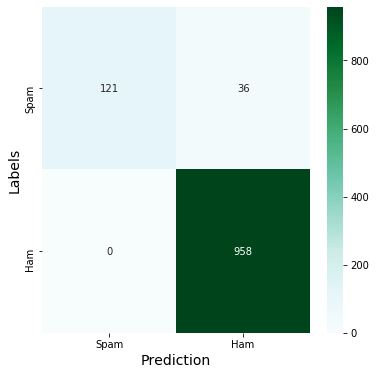


The Classification Report is plotted below: 

               precision    recall  f1-score   support

         ham       0.96      1.00      0.98       958
        spam       1.00      0.77      0.87       157

    accuracy                           0.97      1115
   macro avg       0.98      0.89      0.93      1115
weighted avg       0.97      0.97      0.97      1115

   micro avg	   0.97      0.97      0.97


In [80]:
y_pred = pipeline.predict(msg_test)
y_prob = pipeline.predict_proba(msg_test)[:,1]
print('\nROC-AUC SCORE',roc_auc_score(label_test,y_prob))

print('\nThe Confusion Matrix is plotted below:')
cfmt= pd.DataFrame(confusion_matrix(label_test,y_pred,labels=['spam','ham']),index=['Spam','Ham'],columns=['Spam','Ham'])
plt.figure(figsize=(6,6))
sns.heatmap(cfmt,annot=True,cmap='BuGn',fmt="d")
plt.xlabel("Prediction",fontsize=14)
plt.ylabel("Labels",fontsize=14)
plt.show()
print('\nThe Classification Report is plotted below: \n\n',classification_report(label_test,y_pred))
print('   micro avg\t  ',precision_score(label_test, y_pred, average='micro').round(2),'    ',recall_score(label_test, y_pred, average='micro').round(2),'    ',
      f1_score(label_test, y_pred, average='micro').round(2) )